In [1]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import bean as be
from bean.preprocessing.data_class import VariantSortingReporterScreenData
import matplotlib

In [2]:
plt.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams['pdf.fonttype'] = 42 
matplotlib.rcParams["axes.unicode_minus"] = False

In [3]:
plt.style.use('default')


In [4]:
bdata_path = "../../../results/filtered_annotated/LDLvar/bean_count_LDLvar_annotated.h5ad"

In [5]:
bdata = be.read_h5ad(bdata_path)

In [6]:
bdata.uns['repguide_mask']

,rep5,rep9,rep10,rep11,rep12,rep13,rep14,rep15
name,,,,,,,,
CONTROL_1_g1,1,1,1,1,1,1,1,1
CONTROL_1_g2,1,1,1,1,1,1,1,1
CONTROL_1_g3,1,0,1,1,1,1,1,1
CONTROL_1_g4,1,1,1,1,1,1,1,1
CONTROL_1_g5,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
rs9987289_Maj_ABE_347_g1,1,1,1,1,1,1,1,1
rs9987289_Maj_ABE_347_g2,1,1,1,1,1,1,1,1
rs9987289_Maj_ABE_347_g3,1,1,1,1,1,1,1,1


In [7]:
import pandas as pd

In [8]:
ndata_fullsort = VariantSortingReporterScreenData(
    bdata,)

INFO  @ Thu, 24 Aug 2023 01:32:16:
	 Data has max 5 guides per target element in 'target' column. 



Linear fit of log(a0) ~ log(q): [b0, b1]=[-1.63262892  0.79981362], cov=[[ 3.34100255e-03 -5.43159775e-04]
 [-5.43159775e-04  9.09191631e-05]]
Linear fit of log(pi_a0) ~ log(q): [b0, b1]=[-3.21441876  0.98733643], cov=[[ 0.00929073 -0.00203336]
 [-0.00203336  0.00046306]]


In [9]:
8*4*3455

110560

In [10]:
def get_q(X, sample_size_factors, sample_mask):
    """
    Obtain depth-normalized sample mean
    """
    n_reps, n_condits, n_guides = X.shape
    q_condit_guide = ((X/sample_size_factors[:,:,None])*sample_mask[:,:,None]).sum(axis=0)/sample_mask.sum(axis=0)[:,None]
    assert q_condit_guide.shape == (n_condits, n_guides)
    return(q_condit_guide)

def get_w(X, sample_size_factors, sample_mask = None):
    """
    Obtain depth-normalized sample variance
    """
    n_reps, n_condits, n_guides = X.shape
    if sample_mask is None:
        sample_mask = torch.ones((n_reps, n_condits))
    q = get_q(X, sample_size_factors, sample_mask)
    se = (X/sample_size_factors[:,:,None] - q)**2
    w=(se * sample_mask[:,:,None]).sum(axis=0)/(sample_mask.sum(axis=0))[:,None]
    return(w)

def get_w_c(X, sample_size_factors):
    n_reps, n_condits, n_guides = data.X.shape
    q = get_q(X+1, sample_size_factors)
    residual=(X+1)/sample_size_factors[:,:,None] - q[None,:,:] #(n_reps, n_condits, n_guides)
    covs = torch.zeros((n_condits, n_condits, n_guides))
    for i in range(n_reps):
        for j in range(n_guides):
            covs[:,:,j] += torch.outer(residual[i, :, j].T, residual[i, :, j])
    cov = (1/(n_reps-1))*covs
    return(cov)

def get_z(X, sample_size_factors, sample_mask):
    n_reps, n_condits, n_guides = data.X.shape
    q = get_q(X+1, sample_size_factors, sample_mask)
    z = q/n_reps * (1/sample_size_factors).sum(axis=0)[:,None]
    return(z)

In [11]:
data = ndata_fullsort
w = get_w(data.X, data.size_factor)
z = get_z(data.X, data.size_factor, data.sample_mask)
q = get_q(data.X, data.size_factor, data.sample_mask)

In [12]:
X = data.X
sample_size_factors = data.size_factor

n_reps, n_condits, n_guides = data.X.shape
q = get_q(X, sample_size_factors, data.sample_mask)
n = q.sum(axis=0)
p = q/n[None,:]

In [13]:
multinom_var = n[None,:]*p*(1-p)
r = (w-q)/multinom_var
od = r-1
a0 = ((n-1)/(r - 1 + 1/(1-p)) -1).mean(axis=0)

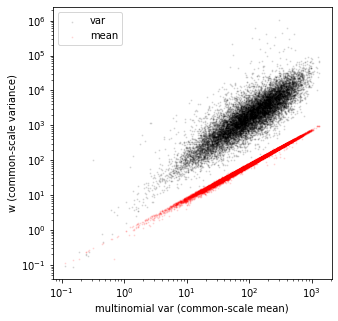

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(q, w, s = 1, alpha = 0.1, c = 'black', label='var')
ax.scatter(q, multinom_var, s = 1, alpha = 0.1, c = 'red', label='mean')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("multinomial var (common-scale mean)")
ax.set_ylabel('w (common-scale variance)')

ax.legend()

In [15]:
"""
Returns fitted alpha 0 (sum of concentration) of Dirichlet-Multinomial
For the notation, see DESeq paper
"""

def get_valid_idx(x:torch.Tensor, y:torch.Tensor):
    return ~(torch.isnan(x) | torch.isnan(y) | torch.isinf(x) | torch.isinf(y))

def get_valid_vals(x, y):
    valid = get_valid_idx(x, y)
    return(x[valid].detach().numpy(), y[valid].detach().numpy())


def get_q(X, sample_size_factors, sample_mask = None):
    """
    Obtain depth-normalized sample mean
    """
    if sample_mask is None:
        sample_mask = torch.ones((n_reps, n_condits))
    n_reps, n_condits, n_guides = X.shape
    q_condit_guide = ((X/sample_size_factors[:,:,None])*sample_mask[:,:,None]).sum(axis=0)/sample_mask.sum(axis=0)[:,None]
    assert q_condit_guide.shape == (n_condits, n_guides)
    return(q_condit_guide)

def get_w(X, sample_size_factors, sample_mask = None):
    """
    Obtain depth-normalized sample variance
    """
    n_reps, n_condits, n_guides = X.shape
    if sample_mask is None:
        sample_mask = torch.ones((n_reps, n_condits))
    q = get_q(X+1, sample_size_factors, sample_mask)
    se = ((X+1)/sample_size_factors[:,:,None] - q)**2
    w=(se * sample_mask[:,:,None]).sum(axis=0)/(sample_mask.sum(axis=0))[:,None]
    return(w)

def linear(x, b0, b1):
    return b0 + b1*x

def get_fitted_alpha0(X, sample_size_factors, sample_mask = None):
    n_reps, n_condits, n_guides = X.shape
    if sample_mask is None:
        sample_mask = torch.ones((n_reps, n_condits))
    w = get_w(X+1, sample_size_factors, sample_mask = sample_mask)
    q = get_q(X+1, sample_size_factors, sample_mask = sample_mask)
    n = q.sum(axis=0)   # depth-normalized total counts across bins
    p = q/n[None,:]     # depth-normalized p for Multinomial
    multinom_var = n[None,:]*p*(1-p)    # theoretical Multinomial variance
    r = (w-q)/multinom_var
    a0 = (n/(r - 1 + 1/(1-p))).mean(axis=0)

    x, y = get_valid_vals(n.log(), a0.log())
    popt, pcov = curve_fit(linear, x, y)
    print("Linear fit of log(a0) ~ log(q): [b0, b1]={}, cov={}".format(popt, pcov))
    a0_est = np.exp(linear(q.sum(axis=0).log().numpy(), *popt))
    return(a0_est)

In [16]:
get_fitted_alpha0(ndata_fullsort.X, ndata_fullsort.size_factor, ndata_fullsort.sample_mask)

Linear fit of log(a0) ~ log(q): [b0, b1]=[-1.51072932  0.7860823 ], cov=[[ 2.80883631e-03 -4.56595256e-04]
 [-4.56595256e-04  7.63919581e-05]]


array([46.998077, 43.544262, 71.83252 , ..., 35.25135 , 20.757826,
       19.45532 ], dtype=float32)

In [17]:
X=data.X
sample_size_factors=data.size_factor
sample_mask = data.sample_mask

w = get_w(X, sample_size_factors, sample_mask = sample_mask)
q = get_q(X, sample_size_factors, sample_mask = sample_mask)
n = q.sum(axis=0)   # depth-normalized total counts across bins
p = q/n[None,:]     # depth-normalized p for Multinomial
multinom_var = n[None,:]*p*(1-p)    # theoretical Multinomial variance
r = w/multinom_var
a0 = ((n-1)/(r - 1 + 1/(1-p))-1).mean(axis=0)

x, y = get_valid_vals(n.log(), a0.log())

In [18]:
def linear(x, b0, b1):
    return b0 + b1*x

In [19]:
def get_valid_idx(x, y):
    return ~(torch.isnan(x) | torch.isnan(y) | torch.isinf(x) | torch.isinf(y))

def get_valid_vals(x, y):
    valid = get_valid_idx(x, y)
    return(x[valid].detach().numpy(), y[valid].detach().numpy())

In [20]:
popt, pcov = curve_fit(linear, x, y)

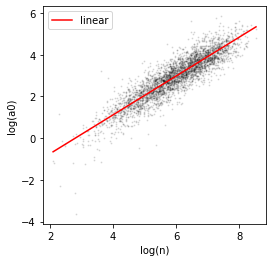

In [21]:
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(x, y, s = 1, alpha = 0.1, c = 'black')
plt.plot(np.sort(x), linear(np.sort(x), *popt), c = 'red', label='linear')
plt.xlabel("log(n)")
plt.ylabel("log(a0)")
plt.legend()

In [22]:
plt.style.use('jr')

In [23]:
q.shape

torch.Size([4, 3451])

In [24]:
multinom_var.shape

torch.Size([4, 3451])

In [25]:
plt.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams['pdf.fonttype'] = 42 
matplotlib.rcParams["axes.unicode_minus"] = False

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'c'
  cset = contour_func(
INFO  @ Thu, 24 Aug 2023 01:32:22:
	 maxp pruned 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 cmap pruned 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 kern dropped 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 post pruned 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 FFTM dropped 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 GPOS pruned 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 GSUB pruned 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 name pruned 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 glyf pruned 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 Added gid0 to subset 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 Added first four glyphs to subset 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 Closing glyph list over 'GSUB': 11 glyphs before 

INFO  @ Thu, 24 Aug 2023 01:32:22:
	 Glyph names: ['.notdef', '.null', 'five', 'four', 'minus', 'nonmarkingr

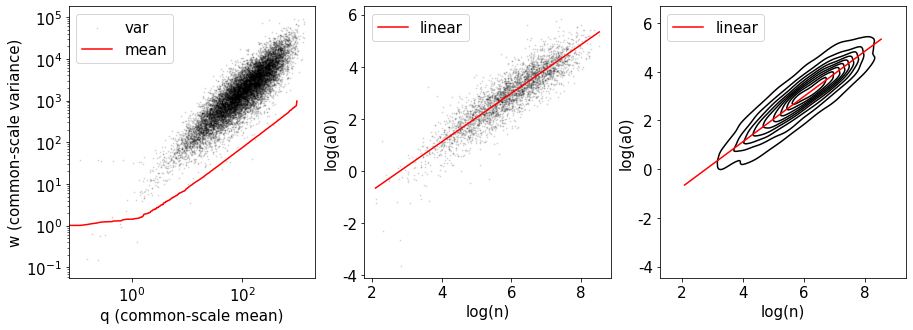

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(q, w, s = 1, alpha = 0.1, c = 'black', label='var', rasterized=True)
ax[0].plot(np.sort(q.flatten()), np.sort(multinom_var.flatten()), c = 'red', label='mean')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("q (common-scale mean)")
ax[0].set_ylabel('w (common-scale variance)')
ax[0].legend()

ax[1].scatter(x, y, s = 1, alpha = 0.1, c = 'black', rasterized=True)
ax[1].plot(np.sort(x), linear(np.sort(x), *popt), c = 'red', label='linear')
ax[1].set_xlabel("log(n)")
ax[1].set_ylabel("log(a0)")
ax[1].legend()

sns.kdeplot(x=x, y=y, c='black', ax = ax[2])
ax[2].plot(np.sort(x), linear(np.sort(x), *popt), c = 'red', label='linear')
ax[2].set_xlabel("log(n)")
ax[2].set_ylabel("log(a0)")
ax[2].legend()

fig.savefig("sorting_bins.pdf")

## Allele alpha


How about the a0 in pi ~ Dir(<pi_0, pi_1>*a0)?

In [27]:
bdata.guides.columns

Index(['Unnamed: 0', 'target_variant', 'Target descriptor', 'Arbitrary number',
       'gRNA position category', 'Target base position in gRNA',
       'Target base position in reporter', 'BE', 'target_group', 'sequence',
       'Reporter', 'barcode', '5-nt PAM', 'offset', 'target',
       'spacer_target_pos', 'target_group2', 'masked_sequence',
       'masked_barcode', 'edit_rate', 'genomic_pos', 'chr'],
      dtype='object')

In [28]:
import bean.preprocessing.get_pi_alpha0 as pa
q = pa.get_q(data.allele_counts_control+1, data.size_factor_control, )
w = pa.get_w(data.allele_counts_control+1, data.size_factor_control, )

In [29]:
q.shape

torch.Size([3451, 2])

In [30]:
n.shape

torch.Size([3451])

In [31]:
n.shape

torch.Size([3451])

In [32]:
p.shape

torch.Size([4, 3451])

In [33]:
n = q.sum(-1)
p = q / q.sum(axis=-1)[:, None]
multinom_var = n[:,None]*p*(1-p)
r = (w - q) / (n[:, None] * p * (1 - p))
a0 = torch.nanmean(((n[:, None] - 1) / (r - 1 + 1 / (1 - p)) - 1), axis=-1)

In [34]:
a0.shape

torch.Size([3451])

WARNING @ Thu, 24 Aug 2023 01:32:23:
	 No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument. 



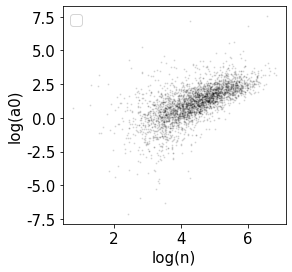

In [35]:
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(n.log(), a0.log(), s = 1, alpha = 0.1, c = 'black')
#plt.plot(np.sort(x), linear(np.sort(x), *popt), c = 'red', label='linear')
plt.xlabel("log(n)")
plt.ylabel("log(a0)")
plt.legend()
#plt.savefig("linear_trend.pdf")

In [36]:
x, y = get_valid_vals(n.log(), a0.log())
popt_allele, pcov = curve_fit(linear, x, y)

In [37]:
plt.rcParams["pdf.use14corefonts"] = True
matplotlib.rcParams['pdf.fonttype'] = 42 
matplotlib.rcParams["axes.unicode_minus"] = False

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/jy_anbe_py38/lib/python3.8/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 's', 'c'
  cset = contour_func(
INFO  @ Thu, 24 Aug 2023 01:32:26:
	 maxp pruned 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 cmap pruned 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 kern dropped 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 post pruned 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 FFTM dropped 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 GPOS pruned 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 GSUB pruned 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 name pruned 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 glyf pruned 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 Added gid0 to subset 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 Added first four glyphs to subset 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 Closing glyph list over 'GSUB': 10 glyphs before 

INFO  @ Thu, 24 Aug 2023 01:32:26:
	 Glyph names: ['.notdef', '.null', 'four', 'minus', 'nonmarkingretu

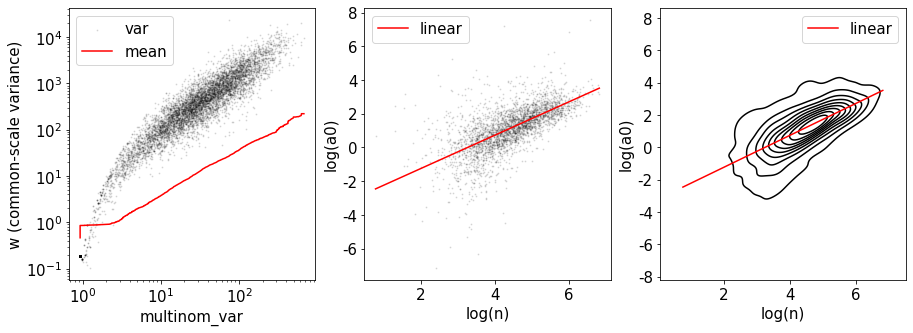

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(q, w, s = 1, alpha = 0.1, c = 'black', label='var', rasterized=True)
ax[0].plot(np.sort(q.flatten()), np.sort(multinom_var.flatten()), c = 'red', label='mean')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("multinom_var")
ax[0].set_ylabel('w (common-scale variance)')
ax[0].legend()

ax[1].scatter(x, y, s = 1, alpha = 0.1, c = 'black', rasterized=True)
ax[1].plot(np.sort(x), linear(np.sort(x), *popt_allele), c = 'red', label='linear')
ax[1].set_xlabel("log(n)")
ax[1].set_ylabel("log(a0)")
ax[1].legend()

sns.kdeplot(x=x, y=y, s = 1, c='black', ax = ax[2])
ax[2].plot(np.sort(x), linear(np.sort(x), *popt_allele), c = 'red', label='linear')
ax[2].set_xlabel("log(n)")
ax[2].set_ylabel("log(a0)")
ax[2].legend()

fig.savefig("alleles.pdf")